# Approach Analysis: Comparing All 4 Quantum Approaches

This notebook analyzes and compares the results from all 4 quantum optimization approaches:
1. **Lightweight Quantum** (BFCD with bilinear entanglement)
2. **Lightweight Hybrid** (BFCD + local search)
3. **Heavyweight Quantum** (TwoLocal with full entanglement)
4. **Heavyweight Hybrid** (TwoLocal + local search)

## Setup and Imports

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pickle
import docplex.mp.model_reader
import json

# add root directory to path
ROOT = Path(os.getcwd()).parent
sys.path.append(str(ROOT))

# project imports
# 1. analysis
from src.step_1 import get_cplex_sol, model_to_obj
from src.experiment import Experiment

print(f"Working directory: {ROOT}")

Working directory: C:\Users\ASUS\Downloads\WISER_Optimization_VG-main


## Data Loading

The `pickle` library is directly used to load data files because these files are in the `./project/results/` directory, not in the `./data/` directory that the `Experiment.read_experiment()` function expects.

In [2]:
experiments = []

# 1. Lightweight Quantum (BFCD)
try:
    with open(ROOT / "project/results" / "exp_lightweight_quantum.pkl", 'rb') as f:
        data = pickle.load(f)
    lw_quantum = Experiment(**data)
    lw_quantum.experiment_id = "Lightweight_Quantum"
    experiments.append(lw_quantum)
    print("✓ Lightweight Quantum loaded")
except Exception as e:
    print(f"✗ Lightweight Quantum not found: {e}")

# 2. Lightweight Hybrid (BFCD + local search)
try:
    with open(ROOT / "project/results" / "exp_lightweight_hybrid.pkl", 'rb') as f:
        data = pickle.load(f)
    lw_hybrid = Experiment(**data)
    lw_hybrid.experiment_id = "Lightweight_Hybrid"
    experiments.append(lw_hybrid)
    print("✓ Lightweight Hybrid loaded")
except Exception as e:
    print(f"✗ Lightweight Hybrid not found: {e}")

# 3. Heavyweight Quantum (TwoLocal)
try:
    with open(ROOT / "project/results" / "exp_heavyweight_quantum.pkl", 'rb') as f:
        data = pickle.load(f)
    hw_quantum = Experiment(**data)
    hw_quantum.experiment_id = "Heavyweight_Quantum"
    experiments.append(hw_quantum)
    print("✓ Heavyweight Quantum loaded")
except Exception as e:
    print(f"✗ Heavyweight Quantum not found: {e}")

# 4. Heavyweight Hybrid (TwoLocal + local search)
try:
    with open(ROOT / "project/results" / "exp_heavyweight_hybrid.pkl", 'rb') as f:
        data = pickle.load(f)
    hw_hybrid = Experiment(**data)
    hw_hybrid.experiment_id = "Heavyweight_Hybrid"
    experiments.append(hw_hybrid)
    print("✓ Heavyweight Hybrid loaded")
except Exception as e:
    print(f"✗ Heavyweight Hybrid not found: {e}")

print(f"\nTotal experiments loaded: {len(experiments)}")

✓ Lightweight Quantum loaded
✓ Lightweight Hybrid loaded
✓ Heavyweight Quantum loaded
✓ Heavyweight Hybrid loaded

Total experiments loaded: 4


## Original DataFrame Construction: Experiment Objects

The process follows a two-step approach to handle data inconsistencies:

1. **Automated**: Uses `Experiment.df_experiments()` to process experiment objects and compute derived metrics like relative gaps and Hamming weights.

2. **Manual**: If automation fails due to missing reference values (`refx`, `refvalue`) or other inconsistencies, a manual method constructs the DataFrame with explicit `None` handling to prevent errors.

In [3]:
# create DataFrame
if len(experiments) > 0:
    try:
        # automated construction
        df_all = Experiment.df_experiments(experiments)
        print(f"DataFrame created with {len(df_all)} experiments and {len(df_all.columns)} columns")
    except Exception as e:
        # if automated construction fails
        print(f"Error creating DataFrame: {e}")
        print("Creating DataFrame manually with None handling...")
        
        # manual construction
        data_list = []
        for exp in experiments:
            # create a dictionary
            exp_data = {
                # extract raw experiment attributes
                'experiment_id': exp.experiment_id,
                'ansatz': exp.ansatz,
                'ansatz_params': exp.ansatz_params,
                'device': exp.device,
                'optimizer': exp.optimizer,
                'alpha': exp.alpha,
                'shots': exp.shots,
                'theta_initial': exp.theta_initial,
                'theta_threshold': exp.theta_threshold,
                'local_search_doe': exp.local_search_doe,
                'lp_file': exp.lp_file,
                'step3_time': exp.step3_time,
                'step4_time': exp.step4_time,
                'step3_fx_evals': exp.step3_fx_evals,
                'step4_iter_best_fx': exp.step4_iter_best_fx,
                'step3_result_best_fx': exp.step3_result_best_fx,
                'step4_result_best_fx': exp.step4_result_best_fx,
                'step3_result_best_x': exp.step3_result_best_x,
                'step4_result_best_x': exp.step4_result_best_x,
                'refx': exp.refx,
                'refvalue': exp.refvalue,
                'has_step4': exp.has_step4(),
                
                # transform raw data into derived metrics
                'step3_x_hamming_weight': sum(np.abs(exp.step3_result_best_x)) if exp.step3_result_best_x is not None else None,
                'step4_x_hamming_weight': sum(np.abs(exp.step4_result_best_x)) if exp.step4_result_best_x is not None else None,
                'step3_rel_gap': (exp.step3_result_best_fx - exp.refvalue) / exp.refvalue if exp.refvalue is not None and exp.refvalue != 0 else None,
                'step4_rel_gap': (exp.step4_result_best_fx - exp.refvalue) / exp.refvalue if exp.step4_result_best_fx is not None and exp.refvalue is not None and exp.refvalue != 0 else None,
                'step3_x_diff': sum(np.abs(exp.refx - exp.step3_result_best_x)) if exp.refx is not None and exp.step3_result_best_x is not None else None,
                'step4_x_diff': sum(np.abs(exp.refx - exp.step4_result_best_x)) if exp.refx is not None and exp.step4_result_best_x is not None else None,
            }
            data_list.append(exp_data)
        
        df_all = pd.DataFrame(data_list)
        print(f"Manual DataFrame created with {len(df_all)} experiments and {len(df_all.columns)} columns")
else:
    print("No experiments loaded - cannot create DataFrame")
    df_all = None

Error creating DataFrame: unsupported operand type(s) for -: 'NoneType' and 'float'
Creating DataFrame manually with None handling...
Manual DataFrame created with 4 experiments and 28 columns


## Original DataFrame Update: Adding Step 4 Function Evaluations

- `step3_fx_evals` **is available** in the original experiment objects. This field records the total function evaluations during Step 3 (quantum optimization). Therefore, it is available for **all approaches (quantum-only & hybrid)**.

- `step4_fx_evals` **is not populated** in the original experiment objects. This field should record the total function evaluations during Step 4 (classical local search), making it relevant **only for hybrid approaches**.
    - However, since `step4_iter_best_fx`, which contains the best objective value at every function call during Step 4, is available, `len(step4_iter_best_fx)` can provide the missing field.

In [4]:
# check existing fields
print(df_all[[col for col in ['experiment_id', 'step3_fx_evals', 'step4_fx_evals', 'step4_iter_best_fx'] if col in df_all.columns]])
print()

# add new field
df_all['step4_fx_evals'] = df_all['step4_iter_best_fx'].apply(
    lambda x: len(x) if x is not None else np.nan
)

# check fields again
print("=" * 55)
print()
print(df_all[[col for col in ['experiment_id', 'step3_fx_evals', 'step4_fx_evals', 'step4_iter_best_fx'] if col in df_all.columns]])

         experiment_id  step3_fx_evals  \
0  Lightweight_Quantum            8191   
1   Lightweight_Hybrid            4096   
2  Heavyweight_Quantum            2791   
3   Heavyweight_Hybrid            1396   

                                  step4_iter_best_fx  
0                                               None  
1  [-2114.9397467779863, -2172.5083676968825, -21...  
2                                               None  
3  [-2223.3132798374104, -2231.7925781106514, -22...  


         experiment_id  step3_fx_evals  step4_fx_evals  \
0  Lightweight_Quantum            8191             NaN   
1   Lightweight_Hybrid            4096          1366.0   
2  Heavyweight_Quantum            2791             NaN   
3   Heavyweight_Hybrid            1396           466.0   

                                  step4_iter_best_fx  
0                                               None  
1  [-2114.9397467779863, -2172.5083676968825, -21...  
2                                               None  
3

## Original DataFrame Update: Adding Benchmark Metrics

This process ensures that all quantum solutions are properly benchmarked against the classical optimal solution.

- **Reference solution** is extracted from the CPLEX solver using the `get_cplex_sol()` function, which loads the LP file `data/1/31bonds/docplex-bin-avgonly-nocplexvars.lp` and computes the optimal solution.

- Reference values (**refx** and **refvalue**) are computed by reading the model with `docplex.mp.model_reader.ModelReader.read()`, creating an objective function with `model_to_obj()`, and solving it with `get_cplex_sol()`.

- The computed reference values are then inserted into the `df_all` DataFrame by updating the `refx` and `refvalue` columns for all experiments.

- **Relative gaps** are updated in the `step3_rel_gap` and `step4_rel_gap` columns after being recomputed using the formula:

$$\mathrm{relative\_gap} = \frac{\mathrm{step\_result\_best\_fx} - \mathrm{refvalue}}{\mathrm{refvalue}}$$

- **Solution differences** are computed by comparing the reference solution vector with the found solutions and stored in `step3_x_diff` and `step4_x_diff` columns.

In [5]:
# compute reference solution and update DataFrame with relative gaps
try:
    # load the LP file and compute reference solution
    lp_file_path = str(ROOT) + '/data/1/31bonds/docplex-bin-avgonly-nocplexvars.lp'
    model = docplex.mp.model_reader.ModelReader.read(lp_file_path)
    obj_fn = model_to_obj(model)
    refx, refvalue = get_cplex_sol(lp_file_path, obj_fn)
    
    print(f"✓ Reference solution computed: {refvalue:.6f}")
    print(f"✓ Reference solution vector: {len(refx)} variables")
    
    # update DataFrame
    if df_all is not None:
        # update reference values
        df_all['refx'] = [refx] * len(df_all)
        df_all['refvalue'] = [refvalue] * len(df_all)
        
        # recompute relative gaps with the computed reference values
        df_all['step3_rel_gap'] = (df_all['step3_result_best_fx'] - refvalue) / refvalue
        df_all['step4_rel_gap'] = (df_all['step4_result_best_fx'] - refvalue) / refvalue
        
        # recompute solution differences
        for idx, row in df_all.iterrows():
            if row['step3_result_best_x'] is not None:
                df_all.loc[idx, 'step3_x_diff'] = sum(np.abs(np.array(refx) - row['step3_result_best_x']))
            if row['step4_result_best_x'] is not None:
                df_all.loc[idx, 'step4_x_diff'] = sum(np.abs(np.array(refx) - row['step4_result_best_x']))
        
        print(f"\n✓ DataFrame updated with computed reference values and relative gaps")
    
except Exception as ref_error:
    print(f"✗ Error computing reference solution: {ref_error}")
    print("Relative gaps will remain as None")

31 15
✓ Reference solution computed: 40.293929
✓ Reference solution vector: 31 variables

✓ DataFrame updated with computed reference values and relative gaps


## Validating Original DataFrame

In [6]:
# display original DataFrame
df_all

,experiment_id,ansatz,ansatz_params,device,optimizer,alpha,shots,theta_initial,theta_threshold,local_search_doe,...,refx,refvalue,has_step4,step3_x_hamming_weight,step4_x_hamming_weight,step3_rel_gap,step4_rel_gap,step3_x_diff,step4_x_diff,step4_fx_evals
0,Lightweight_Quantum,bfcd,"{'reps': 3, 'entanglement': 'bilinear'}",AerSimulator,nft,0.1,1024,piby3,None,None,...,"[0, 1.0, 1.0, 1.0, 0, 0, 1.0, 0, 1.0, 1.0, 1.0...",40.293929,False,24.0,NaN,-56.520432,NaN,13.0,None,NaN
1,Lightweight_Hybrid,bfcd,"{'reps': 3, 'entanglement': 'bilinear'}",AerSimulator,nft,0.1,1024,piby3,None,None,...,"[0, 1.0, 1.0, 1.0, 0, 0, 1.0, 0, 1.0, 1.0, 1.0...",40.293929,True,24.0,24.0,-56.519110,-56.519110,9.0,9.0,1366.0
2,Heavyweight_Quantum,TwoLocal,"{'reps': 2, 'entanglement': 'full'}",AerSimulator,nft,0.1,1024,piby3,None,None,...,"[0, 1.0, 1.0, 1.0, 0, 0, 1.0, 0, 1.0, 1.0, 1.0...",40.293929,False,24.0,NaN,-56.519110,NaN,9.0,None,NaN
3,Heavyweight_Hybrid,TwoLocal,"{'reps': 2, 'entanglement': 'full'}",AerSimulator,nft,0.1,1024,piby3,None,None,...,"[0, 1.0, 1.0, 1.0, 0, 0, 1.0, 0, 1.0, 1.0, 1.0...",40.293929,True,24.0,24.0,-56.517957,-56.517957,15.0,15.0,466.0


In [7]:
# display all columns
print("Available columns in df_all:")
print("-" * 80)
for i, col in enumerate(df_all.columns, 1):
    print(f"{i:2d}. {col}")
print("-" * 80)
print(f"\nTotal columns: {len(df_all.columns)}")

Available columns in df_all:
--------------------------------------------------------------------------------
 1. experiment_id
 2. ansatz
 3. ansatz_params
 4. device
 5. optimizer
 6. alpha
 7. shots
 8. theta_initial
 9. theta_threshold
10. local_search_doe
11. lp_file
12. step3_time
13. step4_time
14. step3_fx_evals
15. step4_iter_best_fx
16. step3_result_best_fx
17. step4_result_best_fx
18. step3_result_best_x
19. step4_result_best_x
20. refx
21. refvalue
22. has_step4
23. step3_x_hamming_weight
24. step4_x_hamming_weight
25. step3_rel_gap
26. step4_rel_gap
27. step3_x_diff
28. step4_x_diff
29. step4_fx_evals
--------------------------------------------------------------------------------

Total columns: 29


## Comparative Analysis

Key performance metrics that are used to compare all approaches are:

1. **Accuracy measured by Hamming distance from the optimal solution vector**:
$$\mathrm{hamming\_distance} = sum(abs(\mathrm{refx} - \mathrm{found\_x}))$$

2. **Relative gap from the optimal solution**:
$$\mathrm{relative\_gap} = \frac{\mathrm{step\_result\_best\_fx} - \mathrm{refvalue}}{\mathrm{refvalue}}$$

3. **Performance differences between quantum-only and hybrid approaches**:
$$\mathrm{hybrid\_improvement} = \mathrm{step4\_result\_best\_fx} - \mathrm{step3\_result\_best\_fx}$$
4. **Lightweight versus heavyweight ansatz configurations**:
$$\mathrm{ansatz\_comparison} = \mathrm{step3\_result\_best\_fx\_heavyweight} - \mathrm{step3\_result\_best\_fx\_lightweight}$$
5. **Entanglement pattern effectiveness**:
$$\mathrm{entanglement\_effectiveness} = \mathrm{performance\_full\_entanglement} - \mathrm{performance\_bilinear\_entanglement}$$

6. **Total execution time**:
$$\mathrm{total\_time} = \mathrm{step3\_time} + \mathrm{step4\_time}$$

## Comparison DataFrame Construction

In [8]:
# create initial comparison DataFrame
df_comparison = pd.DataFrame()

# add basic experiment info
df_comparison['experiment_id'] = df_all['experiment_id']
df_comparison['ansatz'] = df_all['ansatz']
df_comparison['ansatz_params'] = df_all['ansatz_params']
df_comparison['has_step4'] = df_all['has_step4']
df_comparison['step3_result_best_fx'] = df_all['step3_result_best_fx']
df_comparison['step4_result_best_fx'] = df_all['step4_result_best_fx']

### Metric 1: Accuracy measured by Hamming distance from the optimal solution vector

In [9]:
# 1st Metric
print("=========== 1. Solution Vector Comparison ===========")
print()
print(f"Classical Optimal: {refx}")
print()

for idx, row in df_all.iterrows():
    print(f"{row['experiment_id']}:")
    print(f"  Step 3: {row['step3_result_best_x']}")
    print(f"  Step 3 Hamming Distance: {row['step3_x_diff']}")
    
    if row['has_step4']:
        print(f"  Step 4: {row['step4_result_best_x']}")
        print(f"  Step 4 Hamming Distance: {row['step4_x_diff']}")
        
        # show improvement in Hamming distance from Step 3 to Step 4
        hamming_improvement = row['step3_x_diff'] - row['step4_x_diff']
        print(f"  Hamming Distance Improvement: {hamming_improvement}")
    else:
        print(f"  Step 4: Not performed")
    
    print()

# add the metric to comparison DataFrame
df_comparison['step3_hamming_distance'] = df_all['step3_x_diff']
df_comparison['step4_hamming_distance'] = df_all['step4_x_diff']
df_comparison['hamming_improvement'] = df_all['step3_x_diff'] - df_all['step4_x_diff']

# summary table
df_comparison[[col for col in ['experiment_id', 'step3_hamming_distance', 'step4_hamming_distance', 'hamming_improvement'] if col in df_comparison.columns]]

=========== 1. Solution Vector Comparison ===========

Classical Optimal: [0, 1.0, 1.0, 1.0, 0, 0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 0, 1.0, 0, 1.0, 1.0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0, 1.0]

Lightweight_Quantum:
  Step 3: [1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1.
 1. 1. 1. 1. 1. 0. 1.]
  Step 3 Hamming Distance: 13.0
  Step 4: Not performed

Lightweight_Hybrid:
  Step 3: [0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 0.
 1. 1. 1. 1. 1. 1. 1.]
  Step 3 Hamming Distance: 9.0
  Step 4: [0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 0.
 1. 1. 1. 1. 1. 1. 1.]
  Step 4 Hamming Distance: 9.0
  Hamming Distance Improvement: 0.0

Heavyweight_Quantum:
  Step 3: [1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 0. 1. 1. 1. 0.
 1. 1. 0. 1. 1. 1. 1.]
  Step 3 Hamming Distance: 9.0
  Step 4: Not performed

Heavyweight_Hybrid:
  Step 3: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 0. 0. 1. 1. 1. 

,experiment_id,step3_hamming_distance,step4_hamming_distance,hamming_improvement
0,Lightweight_Quantum,13.0,None,NaN
1,Lightweight_Hybrid,9.0,9.0,0.0
2,Heavyweight_Quantum,9.0,None,NaN
3,Heavyweight_Hybrid,15.0,15.0,0.0


### Metric 2: Relative gap from the optimal solution

In [10]:
# 2nd Metric
print("=========== 2. Objective Value Comparison ===========")
print()
print(f"Classical Optimal: {refvalue:.6f}")
print()

for idx, row in df_all.iterrows():
    print(f"{row['experiment_id']}:")
    print(f"  Step 3: {row['step3_result_best_fx']:.6f}")
    print(f"  Step 3 Relative Gap: {row['step3_rel_gap']:.6f}")
    
    if row['has_step4']:
        print(f"  Step 4: {row['step4_result_best_fx']:.6f}")
        print(f"  Step 4 Relative Gap: {row['step4_rel_gap']:.6f}")
        
        # show improvement in relative gap from Step 3 to Step 4
        gap_improvement = row['step3_rel_gap'] - row['step4_rel_gap']
        print(f"  Relative Gap Improvement: {gap_improvement:.6f}")
    else:
        print(f"  Step 4: Not performed")
    
    print()

# add the metric to comparison DataFrame
df_comparison['step3_relative_gap'] = df_all['step3_rel_gap']
df_comparison['step4_relative_gap'] = df_all['step4_rel_gap']
df_comparison['relative_gap_improvement'] = df_all['step3_rel_gap'] - df_all['step4_rel_gap']

# summary table
df_comparison[[col for col in ['experiment_id', 'step3_relative_gap', 'step4_relative_gap', 'relative_gap_improvement'] if col in df_comparison.columns]]

=========== 2. Objective Value Comparison ===========

Classical Optimal: 40.293929

Lightweight_Quantum:
  Step 3: -2237.136366
  Step 3 Relative Gap: -56.520432
  Step 4: Not performed

Lightweight_Hybrid:
  Step 3: -2237.083089
  Step 3 Relative Gap: -56.519110
  Step 4: -2237.083089
  Step 4 Relative Gap: -56.519110
  Relative Gap Improvement: 0.000000

Heavyweight_Quantum:
  Step 3: -2237.083089
  Step 3 Relative Gap: -56.519110
  Step 4: Not performed

Heavyweight_Hybrid:
  Step 3: -2237.036648
  Step 3 Relative Gap: -56.517957
  Step 4: -2237.036648
  Step 4 Relative Gap: -56.517957
  Relative Gap Improvement: 0.000000



,experiment_id,step3_relative_gap,step4_relative_gap,relative_gap_improvement
0,Lightweight_Quantum,-56.520432,NaN,NaN
1,Lightweight_Hybrid,-56.519110,-56.519110,0.0
2,Heavyweight_Quantum,-56.519110,NaN,NaN
3,Heavyweight_Hybrid,-56.517957,-56.517957,0.0


### Metric 3: Performance differences between quantum-only and hybrid approaches

In [11]:
# 3rd Metric
print("=========== 3. Hybrid vs Quantum-Only ===========")
print()

for idx, row in df_all.iterrows():
    if row['has_step4']:
        print(f"{row['experiment_id']}:")
        print(f"  Step 3 (Quantum-only) Objective: {row['step3_result_best_fx']:.6f}")
        print(f"  Step 4 (Hybrid) Objective: {row['step4_result_best_fx']:.6f}")
        
        hybrid_improvement = row['step4_result_best_fx'] - row['step3_result_best_fx']
        print(f"  Hybrid Improvement: {hybrid_improvement:.6f}")
        
        # time analysis
        print(f"  Step 3 Time: {row['step3_time']:.2f}s")
        print(f"  Step 4 Time: {row['step4_time']:.2f}s")
        print(f"  Total Time: {row['step3_time'] + row['step4_time']:.2f}s")
        print()

# add the metric to comparison DataFrame
df_comparison['hybrid_improvement'] = df_all['step4_result_best_fx'] - df_all['step3_result_best_fx']

# summary table
df_comparison[[col for col in ['experiment_id', 'hybrid_improvement'] if col in df_comparison.columns]]

=========== 3. Hybrid vs Quantum-Only ===========

Lightweight_Hybrid:
  Step 3 (Quantum-only) Objective: -2237.083089
  Step 4 (Hybrid) Objective: -2237.083089
  Hybrid Improvement: 0.000000
  Step 3 Time: 7834.85s
  Step 4 Time: 13.62s
  Total Time: 7848.48s

Heavyweight_Hybrid:
  Step 3 (Quantum-only) Objective: -2237.036648
  Step 4 (Hybrid) Objective: -2237.036648
  Hybrid Improvement: 0.000000
  Step 3 Time: 1473.79s
  Step 4 Time: 7.13s
  Total Time: 1480.92s



,experiment_id,hybrid_improvement
0,Lightweight_Quantum,NaN
1,Lightweight_Hybrid,0.0
2,Heavyweight_Quantum,NaN
3,Heavyweight_Hybrid,0.0


### Metric 4: Lightweight versus heavyweight ansatz configurations

In [12]:
# 4th Metric
print()
print("=========== 4. BFCD vs. TwoLocal ===========")
print()

# compare quantum-only approaches
lw_quantum = df_all[df_all['experiment_id'] == 'Lightweight_Quantum'].iloc[0]
hw_quantum = df_all[df_all['experiment_id'] == 'Heavyweight_Quantum'].iloc[0]

print("Quantum-only approaches:")
print(f"  Lightweight (BFCD): {lw_quantum['step3_result_best_fx']:.6f}")
print(f"  Heavyweight (TwoLocal): {hw_quantum['step3_result_best_fx']:.6f}")
ansatz_comparison_quantum = lw_quantum['step3_result_best_fx'] - hw_quantum['step3_result_best_fx']
print(f"  Ansatz Comparison (BFCD - TwoLocal): {ansatz_comparison_quantum:.6f}")
print()

# compare hybrid approaches
lw_hybrid = df_all[df_all['experiment_id'] == 'Lightweight_Hybrid'].iloc[0]
hw_hybrid = df_all[df_all['experiment_id'] == 'Heavyweight_Hybrid'].iloc[0]

print("Hybrid approaches:")
print(f"  Lightweight (BFCD): {lw_hybrid['step4_result_best_fx']:.6f}")
print(f"  Heavyweight (TwoLocal): {hw_hybrid['step4_result_best_fx']:.6f}")
ansatz_comparison_hybrid = lw_hybrid['step4_result_best_fx'] - hw_hybrid['step4_result_best_fx']
print(f"  Ansatz Comparison (BFCD - TwoLocal): {ansatz_comparison_hybrid:.6f}")

# helper function
def df_helper(row):
    if row['experiment_id'] == 'Lightweight_Quantum':
        # for lightweight quantum, compare with heavyweight quantum
        return ansatz_comparison_quantum
    elif row['experiment_id'] == 'Lightweight_Hybrid':
        # for lightweight hybrid, compare with heavyweight hybrid  
        return ansatz_comparison_hybrid
    elif row['experiment_id'] == 'Heavyweight_Quantum':
        # for heavyweight quantum, this is the reference point (no improvement to show)
        return 0.0
    elif row['experiment_id'] == 'Heavyweight_Hybrid':
        # for heavyweight hybrid, this is the reference point (no improvement to show)
        return 0.0
    else:
        return 0.0

# add the metric to comparison DataFrame
df_comparison['ansatz_comparison'] = df_comparison.apply(df_helper, axis=1)

# summary table
df_comparison[[col for col in ['experiment_id', 'ansatz_comparison'] if col in df_comparison.columns]]


=========== 4. BFCD vs. TwoLocal ===========

Quantum-only approaches:
  Lightweight (BFCD): -2237.136366
  Heavyweight (TwoLocal): -2237.083089
  Ansatz Comparison (BFCD - TwoLocal): -0.053277

Hybrid approaches:
  Lightweight (BFCD): -2237.083089
  Heavyweight (TwoLocal): -2237.036648
  Ansatz Comparison (BFCD - TwoLocal): -0.046441


,experiment_id,ansatz_comparison
0,Lightweight_Quantum,-0.053277
1,Lightweight_Hybrid,-0.046441
2,Heavyweight_Quantum,0.000000
3,Heavyweight_Hybrid,0.000000


### Metric 5: Entanglement pattern effectiveness

In [13]:
# 5th Metric
print()
print("=========== 5. Bilinear vs. Full ===========")
print()

# compare quantum-only approaches
lw_quantum = df_all[df_all['experiment_id'] == 'Lightweight_Quantum'].iloc[0]
hw_quantum = df_all[df_all['experiment_id'] == 'Heavyweight_Quantum'].iloc[0]

print("Quantum-only approaches:")
print(f"  Lightweight (Bilinear): {lw_quantum['step3_result_best_fx']:.6f}")
print(f"  Heavyweight (Full): {hw_quantum['step3_result_best_fx']:.6f}")
entanglement_effectiveness_quantum = lw_quantum['step3_result_best_fx'] - hw_quantum['step3_result_best_fx']
print(f"  Entanglement Comparison (Bilinear - Full): {entanglement_effectiveness_quantum:.6f}")
print()

# compare hybrid approaches
lw_hybrid = df_all[df_all['experiment_id'] == 'Lightweight_Hybrid'].iloc[0]
hw_hybrid = df_all[df_all['experiment_id'] == 'Heavyweight_Hybrid'].iloc[0]

print("Hybrid approaches:")
print(f"  Lightweight (Bilinear): {lw_hybrid['step4_result_best_fx']:.6f}")
print(f"  Heavyweight (Full): {hw_hybrid['step4_result_best_fx']:.6f}")
entanglement_effectiveness_hybrid = lw_hybrid['step4_result_best_fx'] - hw_hybrid['step4_result_best_fx']
print(f"  Entanglement Comparison (Bilinear - Full): {entanglement_effectiveness_hybrid:.6f}")

# helper function
def df_helper(row):
    if row['experiment_id'] == 'Lightweight_Quantum':
        # for lightweight quantum, compare with heavyweight quantum
        return entanglement_effectiveness_quantum
    elif row['experiment_id'] == 'Lightweight_Hybrid':
        # for lightweight hybrid, compare with heavyweight hybrid  
        return entanglement_effectiveness_hybrid
    elif row['experiment_id'] == 'Heavyweight_Quantum':
        # for heavyweight quantum, this is the reference point (no improvement to show)
        return 0.0
    elif row['experiment_id'] == 'Heavyweight_Hybrid':
        # for heavyweight hybrid, this is the reference point (no improvement to show)
        return 0.0
    else:
        return 0.0

# add the metric to comparison DataFrame
df_comparison['entanglement_effectiveness'] = df_comparison.apply(df_helper, axis=1)

# summary table
df_comparison[[col for col in ['experiment_id', 'entanglement_effectiveness'] if col in df_comparison.columns]]


=========== 5. Bilinear vs. Full ===========

Quantum-only approaches:
  Lightweight (Bilinear): -2237.136366
  Heavyweight (Full): -2237.083089
  Entanglement Comparison (Bilinear - Full): -0.053277

Hybrid approaches:
  Lightweight (Bilinear): -2237.083089
  Heavyweight (Full): -2237.036648
  Entanglement Comparison (Bilinear - Full): -0.046441


,experiment_id,entanglement_effectiveness
0,Lightweight_Quantum,-0.053277
1,Lightweight_Hybrid,-0.046441
2,Heavyweight_Quantum,0.000000
3,Heavyweight_Hybrid,0.000000


### Metrics 4 and 5: Identical nature
The 4th metric (`ansatz_comparison`: BFCD vs. TwoLocal) and 5th metric (`entanglement_effectiveness`: Bilinear vs. Full) both measure objective function value differences and yield identical values because ansatz type and entanglement pattern are coupled:
- BFCD is always paired with Bilinear entanglement (Lightweight Deep)
- TwoLocal is always paired with Full entanglement (Heavyweight Shallow)

The effects cannot be disentangled as no criss-cross configurations were tested.

In [14]:
# compare 4th and 5th Metrics
df_comparison[[col for col in ['experiment_id', 'ansatz_comparison', 'entanglement_effectiveness'] if col in df_comparison.columns]]

,experiment_id,ansatz_comparison,entanglement_effectiveness
0,Lightweight_Quantum,-0.053277,-0.053277
1,Lightweight_Hybrid,-0.046441,-0.046441
2,Heavyweight_Quantum,0.000000,0.000000
3,Heavyweight_Hybrid,0.000000,0.000000


### Metric 6: Total execution time

In [15]:
# 6th Metric
print()
print("=========== 6. Execution Time ===========")
print()

step3_time_col = []
step4_time_col = []
total_time_col = []
for idx, row in df_all.iterrows():
    print(f"{row['experiment_id']}:")
    print(f"  Step 3 Time: {row['step3_time']:.2f}s")
    step3_time_col.append(row['step3_time'])
    
    if row['has_step4']:
        print(f"  Step 4 Time: {row['step4_time']:.2f}s")
        step4_time_col.append(row['step4_time'])
        total_time = row['step3_time'] + row['step4_time']
        print(f"  Total Time: {total_time:.2f}s")
        total_time_col.append(total_time)
    else:
        print(f"  Step 4 Time: Not performed")
        step4_time_col.append(row['step4_time'])
        print(f"  Total Time: {row['step3_time']:.2f}s")
        total_time_col.append(row['step3_time'])
    print()

# add the metric to comparison DataFrame
df_comparison['step3_time'] = step3_time_col
df_comparison['step4_time'] = step4_time_col
df_comparison['total_time'] = total_time_col

# summary table
df_comparison[[col for col in ['experiment_id', 'step3_time', 'step4_time', 'total_time'] if col in df_comparison.columns]]


=========== 6. Execution Time ===========

Lightweight_Quantum:
  Step 3 Time: 11703.83s
  Step 4 Time: Not performed
  Total Time: 11703.83s

Lightweight_Hybrid:
  Step 3 Time: 7834.85s
  Step 4 Time: 13.62s
  Total Time: 7848.48s

Heavyweight_Quantum:
  Step 3 Time: 4376.98s
  Step 4 Time: Not performed
  Total Time: 4376.98s

Heavyweight_Hybrid:
  Step 3 Time: 1473.79s
  Step 4 Time: 7.13s
  Total Time: 1480.92s



,experiment_id,step3_time,step4_time,total_time
0,Lightweight_Quantum,11703.833385,NaN,11703.833385
1,Lightweight_Hybrid,7834.854870,13.622833,7848.477702
2,Heavyweight_Quantum,4376.981879,NaN,4376.981879
3,Heavyweight_Hybrid,1473.791690,7.131179,1480.922868


In [16]:
# display comparison DataFrame
df_comparison

,experiment_id,ansatz,ansatz_params,has_step4,step3_result_best_fx,step4_result_best_fx,step3_hamming_distance,step4_hamming_distance,hamming_improvement,step3_relative_gap,step4_relative_gap,relative_gap_improvement,hybrid_improvement,ansatz_comparison,entanglement_effectiveness,step3_time,step4_time,total_time
0,Lightweight_Quantum,bfcd,"{'reps': 3, 'entanglement': 'bilinear'}",False,-2237.136366,NaN,13.0,None,NaN,-56.520432,NaN,NaN,NaN,-0.053277,-0.053277,11703.833385,NaN,11703.833385
1,Lightweight_Hybrid,bfcd,"{'reps': 3, 'entanglement': 'bilinear'}",True,-2237.083089,-2237.083089,9.0,9.0,0.0,-56.519110,-56.519110,0.0,0.0,-0.046441,-0.046441,7834.854870,13.622833,7848.477702
2,Heavyweight_Quantum,TwoLocal,"{'reps': 2, 'entanglement': 'full'}",False,-2237.083089,NaN,9.0,None,NaN,-56.519110,NaN,NaN,NaN,0.000000,0.000000,4376.981879,NaN,4376.981879
3,Heavyweight_Hybrid,TwoLocal,"{'reps': 2, 'entanglement': 'full'}",True,-2237.036648,-2237.036648,15.0,15.0,0.0,-56.517957,-56.517957,0.0,0.0,0.000000,0.000000,1473.791690,7.131179,1480.922868


## I. "Quantum vs. Hybrid"

### I(a). Analysis

In [17]:
# extract data from comparison DataFrame
hybrid_experiments = df_comparison[df_comparison['has_step4'] == True]
for _, hybrid_row in hybrid_experiments.iterrows():
    print(f"\n{hybrid_row['experiment_id']}:")
    print(f"  Hamming Improvement: {hybrid_row['hamming_improvement']:.2f}")
    print(f"  Hybrid Improvement: {hybrid_row['hybrid_improvement']:.6f}")
    print(f"  Relative Gap Improvement: {hybrid_row['relative_gap_improvement']:.6f}")
    print(f"  Local Search Time: {hybrid_row['step4_time']:.2f}s")


Lightweight_Hybrid:
  Hamming Improvement: 0.00
  Hybrid Improvement: 0.000000
  Relative Gap Improvement: 0.000000
  Local Search Time: 13.62s

Heavyweight_Hybrid:
  Hamming Improvement: 0.00
  Hybrid Improvement: 0.000000
  Relative Gap Improvement: 0.000000
  Local Search Time: 7.13s


### I(b). Visualization

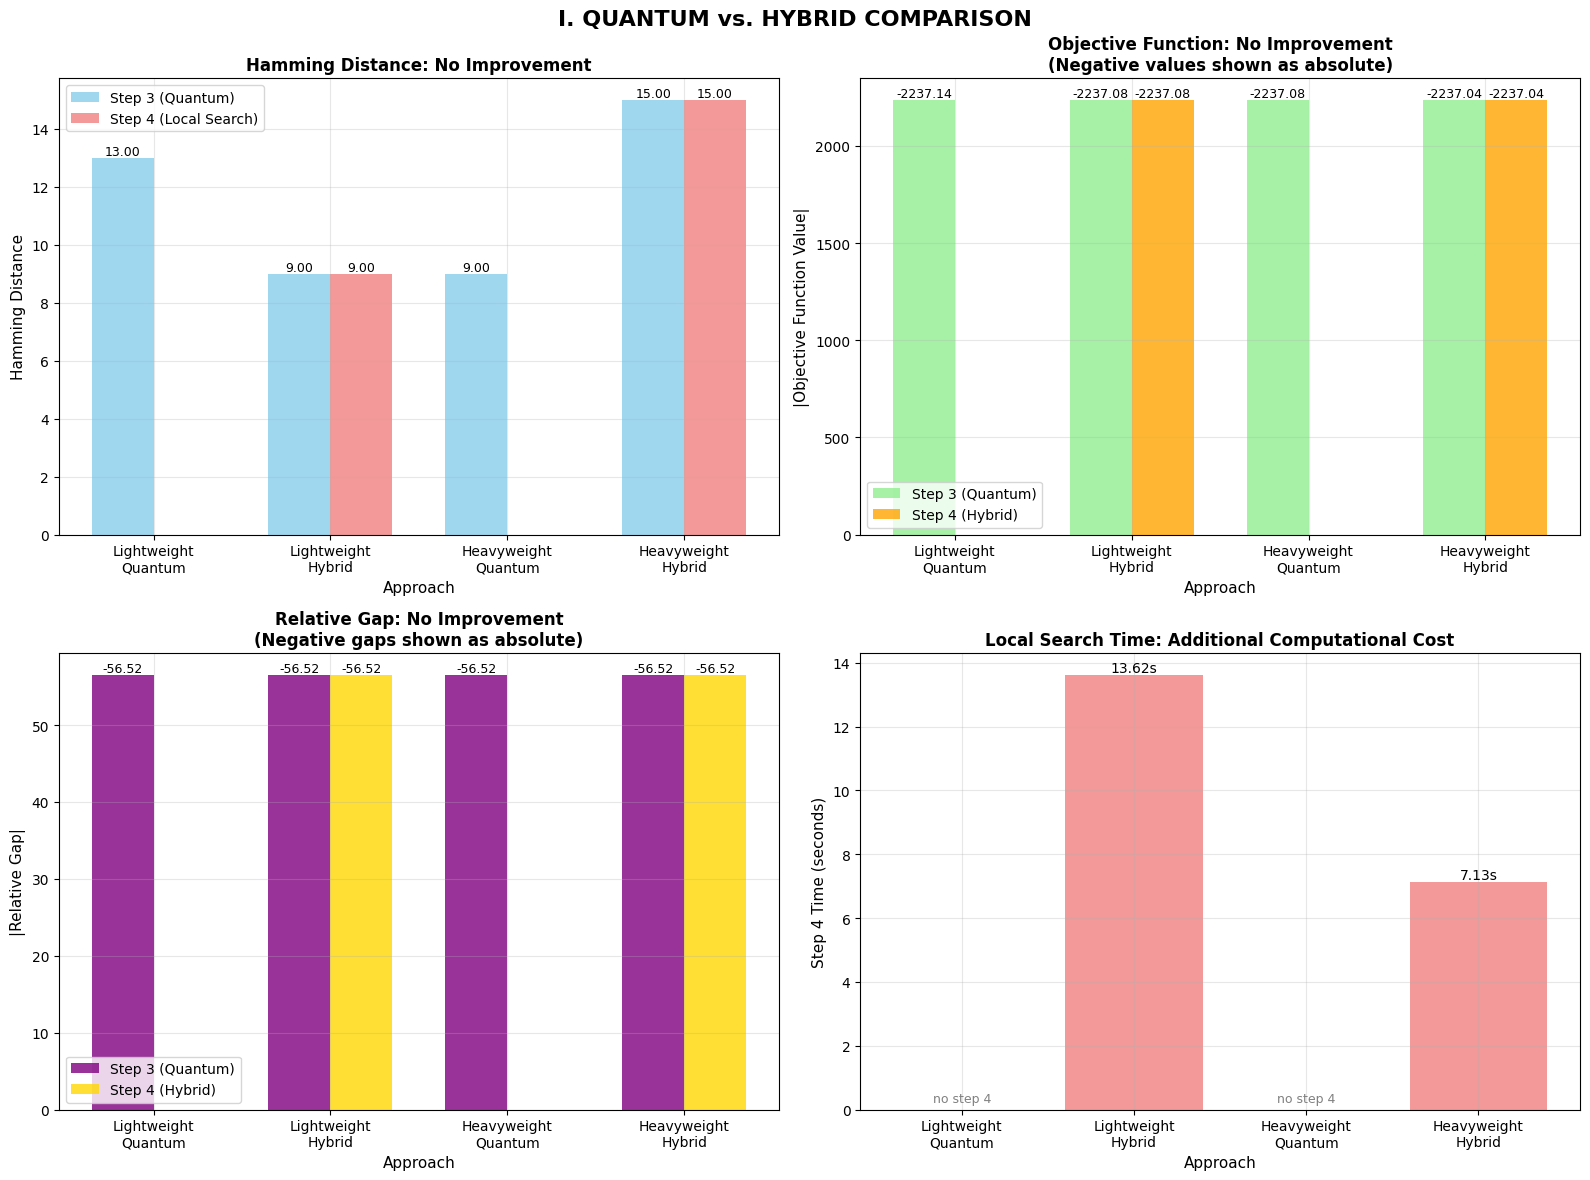

In [18]:
# create visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('I. QUANTUM vs. HYBRID COMPARISON', fontsize=16, fontweight='bold')

# extract data from comparison DataFrame
approach_names = [name.replace('_', '\n') for name in df_comparison['experiment_id']]

######################################################################################
# plot 1: hamming distance comparison (to showcase 0 improvement)

step3_hamming = df_comparison['step3_hamming_distance'].values
step4_hamming = []
for _, row in df_comparison.iterrows():
    if row['has_step4']:  # hybrid approach
        step4_hamming.append(row['step3_hamming_distance'])  # same as step 3 (no improvement)
    else:  # quantum-only approach
        step4_hamming.append(0)  # no step 4 performed
step4_hamming = np.array(step4_hamming)

x = np.arange(len(approach_names))
width = 0.35

bars1 = axes[0, 0].bar(x - width/2, step3_hamming, width, label='Step 3 (Quantum)', 
                       color='skyblue', alpha=0.8)
bars2 = axes[0, 0].bar(x + width/2, step4_hamming, width, label='Step 4 (Local Search)', 
                       color='lightcoral', alpha=0.8)

axes[0, 0].set_xlabel('Approach', fontsize=11)
axes[0, 0].set_ylabel('Hamming Distance', fontsize=11)
axes[0, 0].set_title('Hamming Distance: No Improvement', fontsize=12, fontweight='bold')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(approach_names, rotation=0, ha='center', fontsize=10)
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(True, alpha=0.3)

# add value labels on bars (show original values)
for bar in bars1:
    height = bar.get_height()
    axes[0, 0].text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.2f}', ha='center', va='bottom', fontsize=9)

for i, bar in enumerate(bars2):
    height = bar.get_height()
    if step4_hamming[i] > 0:  # only label if not zero (hybrid approaches only)
        axes[0, 0].text(bar.get_x() + bar.get_width()/2., height,
                        f'{height:.2f}', ha='center', va='bottom', fontsize=9)

######################################################################################
# plot 2: objective function comparison (to showcase 0 hybrid improvement)

# convert to absolute values for better visualization
step3_obj = df_all['step3_result_best_fx'].values
step3_obj_abs = np.abs(step3_obj)
step4_obj_abs = []
for _, row in df_comparison.iterrows():
    if row['has_step4']:  # hybrid approach
        step4_obj_abs.append(abs(row['step3_result_best_fx']))  # same as step 3 (no improvement)
    else:  # quantum-only approach
        step4_obj_abs.append(0)  # no step 4 performed
step4_obj_abs = np.array(step4_obj_abs)

bars1 = axes[0, 1].bar(x - width/2, step3_obj_abs, width, label='Step 3 (Quantum)', 
                       color='lightgreen', alpha=0.8)
bars2 = axes[0, 1].bar(x + width/2, step4_obj_abs, width, label='Step 4 (Hybrid)', 
                       color='orange', alpha=0.8)

axes[0, 1].set_xlabel('Approach', fontsize=11)
axes[0, 1].set_ylabel('|Objective Function Value|', fontsize=11)
axes[0, 1].set_title('Objective Function: No Improvement\n(Negative values shown as absolute)', fontsize=12, fontweight='bold')
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(approach_names, rotation=0, ha='center', fontsize=10)
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(True, alpha=0.3)

# add value labels on bars (show original negative values)
for i, (bar, orig_val) in enumerate(zip(bars1, step3_obj)):
    height = bar.get_height()
    axes[0, 1].text(bar.get_x() + bar.get_width()/2., height,
                    f'{orig_val:.2f}', ha='center', va='bottom', fontsize=9)

for i, (bar, orig_val) in enumerate(zip(bars2, step3_obj)):  # same values as step 3
    if step4_obj_abs[i] > 0:  # only label if not zero
        height = bar.get_height()
        axes[0, 1].text(bar.get_x() + bar.get_width()/2., height,
                        f'{orig_val:.2f}', ha='center', va='bottom', fontsize=9)

######################################################################################
# plot 3: relative gap comparison (to showcase 0 improvement)

# convert to absolute values for better visualization
step3_gap = df_comparison['step3_relative_gap'].values
step3_gap_abs = np.abs(step3_gap)
step4_gap_abs = []
for _, row in df_comparison.iterrows():
    if row['has_step4']:  # hybrid approach
        step4_gap_abs.append(abs(row['step3_relative_gap']))  # same as step 3 (no improvement)
    else:  # quantum-only approach
        step4_gap_abs.append(0)  # no step 4 performed
step4_gap_abs = np.array(step4_gap_abs)

bars1 = axes[1, 0].bar(x - width/2, step3_gap_abs, width, label='Step 3 (Quantum)', 
                       color='purple', alpha=0.8)
bars2 = axes[1, 0].bar(x + width/2, step4_gap_abs, width, label='Step 4 (Hybrid)', 
                       color='gold', alpha=0.8)

axes[1, 0].set_xlabel('Approach', fontsize=11)
axes[1, 0].set_ylabel('|Relative Gap|', fontsize=11)
axes[1, 0].set_title('Relative Gap: No Improvement\n(Negative gaps shown as absolute)', fontsize=12, fontweight='bold')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(approach_names, rotation=0, ha='center', fontsize=10)
axes[1, 0].legend(fontsize=10)
axes[1, 0].grid(True, alpha=0.3)

# add value labels on bars (show original negative values)
for i, (bar, orig_val) in enumerate(zip(bars1, step3_gap)):
    height = bar.get_height()
    axes[1, 0].text(bar.get_x() + bar.get_width()/2., height,
                    f'{orig_val:.2f}', ha='center', va='bottom', fontsize=9)

for i, (bar, orig_val) in enumerate(zip(bars2, step3_gap)):  # same values as step 3
    if step4_gap_abs[i] > 0:  # only label if not zero
        height = bar.get_height()
        axes[1, 0].text(bar.get_x() + bar.get_width()/2., height,
                        f'{orig_val:.2f}', ha='center', va='bottom', fontsize=9)

######################################################################################
# plot 4: step 4 time (to showcase time taken for local search)

step4_times = []
for _, row in df_comparison.iterrows():
    if pd.notna(row['step4_time']):  # hybrid approach
        step4_times.append(row['step4_time'])
    else:  # quantum-only approach
        step4_times.append(0)  # no step 4 performed
step4_times = np.array(step4_times)

colors = ['gray', 'lightcoral', 'gray', 'lightcoral']  # gray for quantum-only, lightcoral for hybrid
bars = axes[1, 1].bar(range(len(approach_names)), step4_times, 
                      color=colors, alpha=0.8)

axes[1, 1].set_xlabel('Approach', fontsize=11)
axes[1, 1].set_ylabel('Step 4 Time (seconds)', fontsize=11)
axes[1, 1].set_title('Local Search Time: Additional Computational Cost', fontsize=12, fontweight='bold')
axes[1, 1].set_xticks(range(len(approach_names)))
axes[1, 1].set_xticklabels(approach_names, rotation=0, ha='center', fontsize=10)
axes[1, 1].grid(True, alpha=0.3)

# add value labels on bars (show original values)
for i, (bar, time) in enumerate(zip(bars, step4_times)):
    if time > 0:
        axes[1, 1].text(bar.get_x() + bar.get_width()/2., time,
                        f'{time:.2f}s', ha='center', va='bottom', fontsize=10)
    else:
        axes[1, 1].text(bar.get_x() + bar.get_width()/2., max(step4_times)*0.01,
                        'no step 4', ha='center', va='bottom', fontsize=9, color='gray')

######################################################################################

plt.tight_layout()
plt.show()

### I(c). Conclusion
**Question**: Does classical post-processing help reach target quality faster?

**Answer**: Based on the data, classical post-processing (hybrid approach) **does not improve** solution quality.
- The found solutions after local search show no improvement in Hamming distance compared to the optimal solution.
    - 0 in `hamming_improvement`
- The objective value of hybrid solutions shows no improvement over those found without post-processing.
    - 0 in `hybrid_improvement`
- There is no observed benefit when comparing hybrid vs. non-hybrid solutions, and no reduction in the relative gap to the optimal.
    - 0 in `relative_gap_improvement`
- It requires additional time without providing any benefit.

## II. "Lightweight Deep vs. Heavyweight Shallow"

### II(a). Analysis

In the project setup, two main configuration axes are defined:

1. **Circuit type** definitions:
    - Lightweight: BFCD ansatz + bilinear entanglement
    - Heavyweight: TwoLocal ansatz + full entanglement

2. **Depth** definitions:
    - Deep: 3 repetitions
    - Shallow: 2 repetitions


By combining circuit type and depth, distinct configurations are formed to explore the impact of circuit complexity on performance:

- **Lightweight deep**:
    - Quantum only: BFCD + bilinear entanglement + 3 repetitions
    - Hybrid: BFCD + bilinear entanglement + 3 repetitions + local search

- **Heavyweight shallow**:
    - Quantum only: TwoLocal + full entanglement + 2 repetitions
    - Hybrid: TwoLocal + full entanglement + 2 repetitions + local search

In [19]:
# quantum-only
print("=== QUANTUM-ONLY COMPARISON ===")

lwq_id = 'Lightweight_Quantum'
hwq_id = 'Heavyweight_Quantum'

# lightweight quantum
lwq_row = df_comparison[df_comparison['experiment_id'] == lwq_id].iloc[0]
lwq_params = lwq_row['ansatz_params']
lwq_ent = lwq_params.get('entanglement') if isinstance(lwq_params, dict) else 'n/a'
lwq_obj = lwq_row['step3_result_best_fx'] # use step3 results
lwq_gap = lwq_row['step3_relative_gap']   # use step3 results

# format reps with deep/shallow
lwq_reps = lwq_params.get('reps') if isinstance(lwq_params, dict) else 'n/a'
try:
    reps_int = int(lwq_reps)
    reps_label = f"{reps_int} ({'deep' if reps_int >= 3 else 'shallow'})"
except:
    reps_label = str(lwq_reps) if lwq_reps is not None else "n/a"

print("\nlightweight quantum:")
print(f"  ansatz: {lwq_row['ansatz']}")
print(f"  entanglement: {lwq_ent if lwq_ent is not None else 'n/a'}")
print(f"  reps: {reps_label}")
print(f"  objective value: {lwq_obj:.6f}")
print(f"  relative gap: {lwq_gap:.6f}")

######################################################################################

# heavyweight quantum
hwq_row = df_comparison[df_comparison['experiment_id'] == hwq_id].iloc[0]
hwq_params = hwq_row['ansatz_params']
hwq_ent = hwq_params.get('entanglement') if isinstance(hwq_params, dict) else 'n/a'
hwq_obj = hwq_row['step3_result_best_fx'] # use step3 results
hwq_gap = hwq_row['step3_relative_gap']   # use step3 results

# format reps with deep/shallow
hwq_reps = hwq_params.get('reps') if isinstance(hwq_params, dict) else 'n/a'
try:
    reps_int = int(hwq_reps)
    reps_label = f"{reps_int} ({'deep' if reps_int >= 3 else 'shallow'})"
except:
    reps_label = str(hwq_reps) if hwq_reps is not None else "n/a"

print("\nheavyweight quantum:")
print(f"  ansatz: {hwq_row['ansatz']}")
print(f"  entanglement: {hwq_ent if hwq_ent is not None else 'n/a'}")
print(f"  reps: {reps_label}")
print(f"  objective value: {hwq_obj:.6f}")
print(f"  relative gap: {hwq_gap:.6f}")

######################################################################################

# hybrid
print("\n=== HYBRID COMPARISON ===")

lwh_id = 'Lightweight_Hybrid'
hwh_id = 'Heavyweight_Hybrid'

# lightweight hybrid
lwh_row = df_comparison[df_comparison['experiment_id'] == lwh_id].iloc[0]
lwh_params = lwh_row['ansatz_params']
lwh_ent = lwh_params.get('entanglement') if isinstance(lwh_params, dict) else 'n/a'
lwh_obj = lwh_row['step4_result_best_fx'] # use step4 results
lwh_gap = lwh_row['step4_relative_gap']   # use step4 results

# format reps with deep/shallow
lwh_reps = lwh_params.get('reps') if isinstance(lwh_params, dict) else 'n/a'
try:
    reps_int = int(lwh_reps)
    reps_label = f"{reps_int} ({'deep' if reps_int >= 3 else 'shallow'})"
except:
    reps_label = str(lwh_reps) if lwh_reps is not None else "n/a"

print("\nlightweight hybrid:")
print(f"  ansatz: {lwh_row['ansatz']}")
print(f"  entanglement: {lwh_ent if lwh_ent is not None else 'n/a'}")
print(f"  reps: {reps_label}")
print(f"  objective value: {lwh_obj:.6f}")
print(f"  relative gap: {lwh_gap:.6f}")

######################################################################################

# heavyweight hybrid
hwh_row = df_comparison[df_comparison['experiment_id'] == hwh_id].iloc[0]
hwh_params = hwh_row['ansatz_params']
hwh_ent = hwh_params.get('entanglement') if isinstance(hwh_params, dict) else 'n/a'
hwh_obj = hwh_row['step4_result_best_fx'] # use step4 results
hwh_gap = hwh_row['step4_relative_gap']   # use step4 results

# format reps with deep/shallow
hwh_reps = hwh_params.get('reps') if isinstance(hwh_params, dict) else 'n/a'
try:
    reps_int = int(hwh_reps)
    reps_label = f"{reps_int} ({'deep' if reps_int >= 3 else 'shallow'})"
except:
    reps_label = str(hwh_reps) if hwh_reps is not None else "n/a"

print("\nheavyweight hybrid:")
print(f"  ansatz: {hwh_row['ansatz']}")
print(f"  entanglement: {hwh_ent if hwh_ent is not None else 'n/a'}")
print(f"  reps: {reps_label}")
print(f"  objective value: {hwh_obj:.6f}")
print(f"  relative gap: {hwh_gap:.6f}")

######################################################################################

# display comparison DataFrame
df_comparison[[col for col in ['experiment_id', 'ansatz', 'ansatz_params', 'step3_result_best_fx', 'step4_result_best_fx', 'step3_relative_gap', 'step4_relative_gap'] if col in df_comparison.columns]]

=== QUANTUM-ONLY COMPARISON ===

lightweight quantum:
  ansatz: bfcd
  entanglement: bilinear
  reps: 3 (deep)
  objective value: -2237.136366
  relative gap: -56.520432

heavyweight quantum:
  ansatz: TwoLocal
  entanglement: full
  reps: 2 (shallow)
  objective value: -2237.083089
  relative gap: -56.519110

=== HYBRID COMPARISON ===

lightweight hybrid:
  ansatz: bfcd
  entanglement: bilinear
  reps: 3 (deep)
  objective value: -2237.083089
  relative gap: -56.519110

heavyweight hybrid:
  ansatz: TwoLocal
  entanglement: full
  reps: 2 (shallow)
  objective value: -2237.036648
  relative gap: -56.517957


,experiment_id,ansatz,ansatz_params,step3_result_best_fx,step4_result_best_fx,step3_relative_gap,step4_relative_gap
0,Lightweight_Quantum,bfcd,"{'reps': 3, 'entanglement': 'bilinear'}",-2237.136366,NaN,-56.520432,NaN
1,Lightweight_Hybrid,bfcd,"{'reps': 3, 'entanglement': 'bilinear'}",-2237.083089,-2237.083089,-56.519110,-56.519110
2,Heavyweight_Quantum,TwoLocal,"{'reps': 2, 'entanglement': 'full'}",-2237.083089,NaN,-56.519110,NaN
3,Heavyweight_Hybrid,TwoLocal,"{'reps': 2, 'entanglement': 'full'}",-2237.036648,-2237.036648,-56.517957,-56.517957


### II(b). Visualization

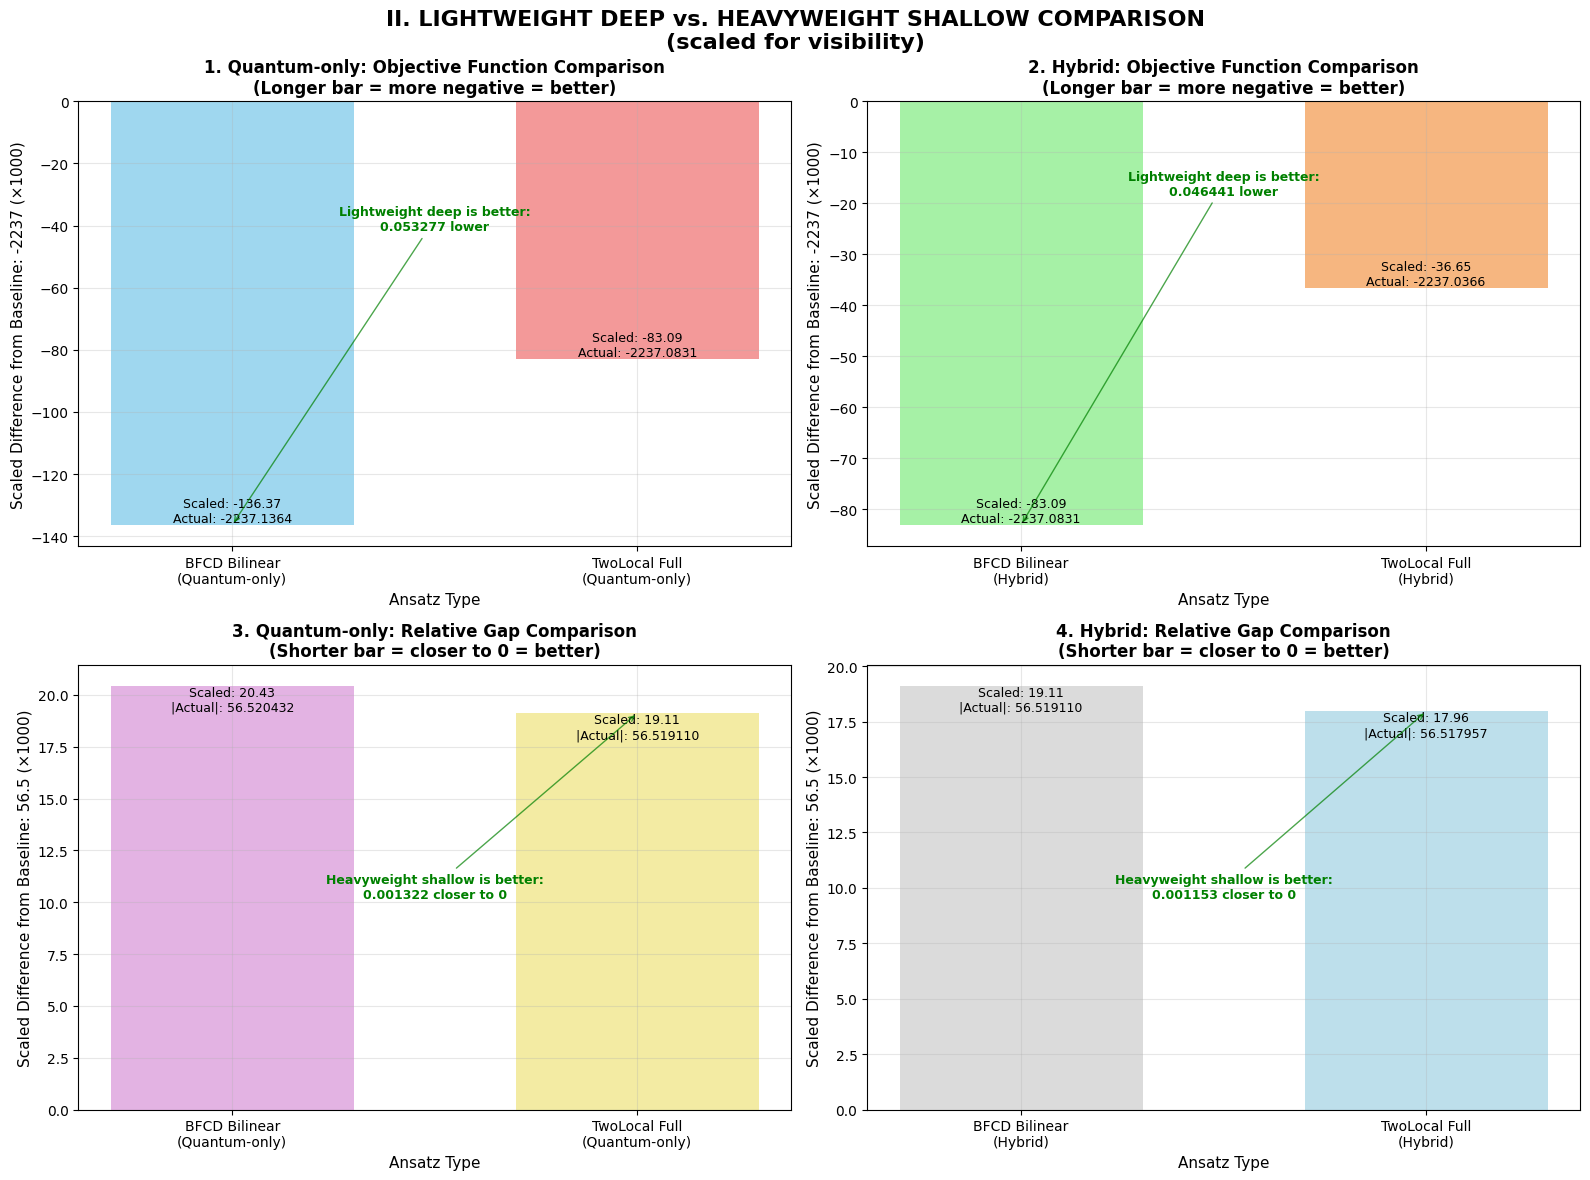

In [20]:
# create visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('II. LIGHTWEIGHT DEEP vs. HEAVYWEIGHT SHALLOW COMPARISON\n(scaled for visibility)', fontsize=16, fontweight='bold')

# extract data from comparison DataFrame
lw_quantum = df_comparison[df_comparison['experiment_id'] == 'Lightweight_Quantum'].iloc[0]
hw_quantum = df_comparison[df_comparison['experiment_id'] == 'Heavyweight_Quantum'].iloc[0]
lw_hybrid = df_comparison[df_comparison['experiment_id'] == 'Lightweight_Hybrid'].iloc[0]
hw_hybrid = df_comparison[df_comparison['experiment_id'] == 'Heavyweight_Hybrid'].iloc[0]

# get objective function values from joined DataFrame (original values)
lw_quantum_obj = lw_quantum['step3_result_best_fx']
hw_quantum_obj = hw_quantum['step3_result_best_fx']
lw_hybrid_obj = lw_hybrid['step4_result_best_fx']
hw_hybrid_obj = hw_hybrid['step4_result_best_fx']

######################################################################################
# plot 1: objective function value comparison - lightweight quantum (BFCD) vs. heavyweight quantum (TwoLocal)

ansatz_types_quantum = ['BFCD Bilinear\n(Quantum-only)', 'TwoLocal Full\n(Quantum-only)']
quantum_objectives_orig = [lw_quantum_obj, hw_quantum_obj]

# manipulate data to show deviation from rounded minimum (nearest integer)
quantum_obj_min = min(quantum_objectives_orig)
quantum_obj_min_rounded = round(quantum_obj_min)  # round to nearest integer
quantum_objectives_scaled = [val - quantum_obj_min_rounded for val in quantum_objectives_orig]

# multiply by a scale factor to make differences more visible
scale_factor_obj = 1000
quantum_objectives_display = [val * scale_factor_obj for val in quantum_objectives_scaled]

x = np.arange(len(ansatz_types_quantum))
width = 0.6

# create bars showing scaled objective function differences from baseline
bars = axes[0, 0].bar(x, quantum_objectives_display, width, 
                      color=['skyblue', 'lightcoral'], alpha=0.8)

axes[0, 0].set_xlabel('Ansatz Type', fontsize=11)
axes[0, 0].set_ylabel(f'Scaled Difference from Baseline: {quantum_obj_min_rounded} (×{scale_factor_obj})', fontsize=11)
axes[0, 0].set_title('1. Quantum-only: Objective Function Comparison\n(Longer bar = more negative = better)', fontsize=12, fontweight='bold')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(ansatz_types_quantum, rotation=0, ha='center', fontsize=10)
axes[0, 0].grid(True, alpha=0.3)

# add value labels on bars (show both scaled and original values)
for bar, val_display, val_orig in zip(bars, quantum_objectives_display, quantum_objectives_orig):
    height = bar.get_height()
    axes[0, 0].text(bar.get_x() + bar.get_width()/2., height,
                    f'Scaled: {val_display:.2f}\nActual: {val_orig:.4f}', 
                    ha='center', va='bottom', fontsize=9)

# add comparison annotation - for minimization, more negative (longer bar) is better
improvement = ansatz_comparison_quantum  # or entanglement_effectiveness_quantum
if improvement > 0:
    # TwoLocal is better (higher BFCD value - lower TwoLocal value)
    axes[0, 0].annotate(f'Heavyweight shallow is better:\n{improvement:.6f} lower', 
                       xy=(1, quantum_objectives_display[1]), xytext=(0.5, max(quantum_objectives_display)*0.5),
                       arrowprops=dict(arrowstyle='->', color='red', alpha=0.7),
                       fontsize=9, ha='center', color='red', fontweight='bold')
else:
    # BFCD is better (lower BFCD value - higher TwoLocal value)
    axes[0, 0].annotate(f'Lightweight deep is better:\n{abs(improvement):.6f} lower', 
                       xy=(0, quantum_objectives_display[0]), xytext=(0.5, max(quantum_objectives_display)*0.5),
                       arrowprops=dict(arrowstyle='->', color='green', alpha=0.7),
                       fontsize=9, ha='center', color='green', fontweight='bold')

######################################################################################
# plot 2: objective function value comparison - lightweight hybrid (BFCD) vs. heavyweight hybrid (TwoLocal)

ansatz_types_hybrid = ['BFCD Bilinear\n(Hybrid)', 'TwoLocal Full\n(Hybrid)']
hybrid_objectives_orig = [lw_hybrid_obj, hw_hybrid_obj]

# manipulate data to show deviation from rounded minimum (nearest integer)
hybrid_obj_min = min(hybrid_objectives_orig)
hybrid_obj_min_rounded = round(hybrid_obj_min)  # round to nearest integer
hybrid_objectives_scaled = [val - hybrid_obj_min_rounded for val in hybrid_objectives_orig]

# multiply by scale factor to make differences more visible
scale_factor_obj = 1000
hybrid_objectives_display = [val * scale_factor_obj for val in hybrid_objectives_scaled]

x = np.arange(len(ansatz_types_hybrid))
width = 0.6

# create bars showing scaled objective function differences from baseline
bars = axes[0, 1].bar(x, hybrid_objectives_display, width, 
                      color=['lightgreen', 'sandybrown'], alpha=0.8)

axes[0, 1].set_xlabel('Ansatz Type', fontsize=11)
axes[0, 1].set_ylabel(f'Scaled Difference from Baseline: {hybrid_obj_min_rounded} (×{scale_factor_obj})', fontsize=11)
axes[0, 1].set_title('2. Hybrid: Objective Function Comparison\n(Longer bar = more negative = better)', fontsize=12, fontweight='bold')
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(ansatz_types_hybrid, rotation=0, ha='center', fontsize=10)
axes[0, 1].grid(True, alpha=0.3)

# add value labels on bars (show both scaled and original values)
for bar, val_display, val_orig in zip(bars, hybrid_objectives_display, hybrid_objectives_orig):
    height = bar.get_height()
    axes[0, 1].text(bar.get_x() + bar.get_width()/2., height,
                    f'Scaled: {val_display:.2f}\nActual: {val_orig:.4f}', 
                    ha='center', va='bottom', fontsize=9)

# add comparison annotation - for minimization, more negative (longer bar) is better
improvement = ansatz_comparison_hybrid  # or entanglement_effectiveness_hybrid
if improvement > 0:
    # TwoLocal is better (higher BFCD value - lower TwoLocal value)
    axes[0, 1].annotate(f'Heavyweight shallow is better:\n{improvement:.6f} lower', 
                       xy=(1, hybrid_objectives_display[1]), xytext=(0.5, max(hybrid_objectives_display)*0.5),
                       arrowprops=dict(arrowstyle='->', color='red', alpha=0.7),
                       fontsize=9, ha='center', color='red', fontweight='bold')
else:
    # BFCD is better (lower BFCD value - higher TwoLocal value)
    axes[0, 1].annotate(f'Lightweight deep is better:\n{abs(improvement):.6f} lower', 
                       xy=(0, hybrid_objectives_display[0]), xytext=(0.5, max(hybrid_objectives_display)*0.5),
                       arrowprops=dict(arrowstyle='->', color='green', alpha=0.7),
                       fontsize=9, ha='center', color='green', fontweight='bold')

######################################################################################
# plot 3: relative gap comparison - lightweight quantum (BFCD) vs. heavyweight quantum (TwoLocal)

quantum_gaps_orig = [lw_quantum['step3_relative_gap'], hw_quantum['step3_relative_gap']]

# manipulate data to show deviation from rounded-down minimum (floor to 1 decimal)
quantum_gaps_abs = [abs(val) for val in quantum_gaps_orig]
quantum_gaps_baseline = np.floor(min(quantum_gaps_abs) * 10) / 10  # round down to 1 decimal
quantum_gaps_scaled = [val - quantum_gaps_baseline for val in quantum_gaps_abs]

# multiply by a scale factor to make differences more visible
scale_factor_gap = 1000
quantum_gaps_display = [val * scale_factor_gap for val in quantum_gaps_scaled]

x = np.arange(len(ansatz_types_quantum))
width = 0.6

# create bars showing scaled relative gap differences from baseline
bars = axes[1, 0].bar(x, quantum_gaps_display, width, 
                      color=['plum', 'khaki'], alpha=0.8)

axes[1, 0].set_xlabel('Ansatz Type', fontsize=11)
axes[1, 0].set_ylabel(f'Scaled Difference from Baseline: {quantum_gaps_baseline:.1f} (×{scale_factor_gap})', fontsize=11)
axes[1, 0].set_title('3. Quantum-only: Relative Gap Comparison\n(Shorter bar = closer to 0 = better)', fontsize=12, fontweight='bold')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(ansatz_types_quantum, rotation=0, ha='center', fontsize=10)
axes[1, 0].grid(True, alpha=0.3)

# add value labels on bars (show both scaled and original values)
for bar, val_display, val_orig, val_abs in zip(bars, quantum_gaps_display, quantum_gaps_orig, quantum_gaps_abs):
    height = bar.get_height()
    axes[1, 0].text(bar.get_x() + bar.get_width()/2., height,
                    f'Scaled: {val_display:.2f}\n|Actual|: {val_abs:.6f}', 
                    ha='center', va='top', fontsize=9)

# add comparison annotation - for gaps, closer to 0 (shorter bar) is better
gap_improvement = abs(lw_quantum['step3_relative_gap']) - abs(hw_quantum['step3_relative_gap'])
if gap_improvement > 0:
    # TwoLocal is better (higher BFCD value - lower TwoLocal value)
    axes[1, 0].annotate(f'Heavyweight shallow is better:\n{abs(gap_improvement):.6f} closer to 0', 
                       xy=(1, quantum_gaps_display[1]), xytext=(0.5, max(quantum_gaps_display)*0.5),
                       arrowprops=dict(arrowstyle='->', color='green', alpha=0.7),
                       fontsize=9, ha='center', color='green', fontweight='bold')
else:
    # BFCD is better (lower BFCD value - higher TwoLocal value)
    axes[1, 0].annotate(f'Lightweight deep is better:\n{abs(gap_improvement):.6f} closer to 0', 
                       xy=(0, quantum_gaps_display[0]), xytext=(0.5, max(quantum_gaps_display)*0.5),
                       arrowprops=dict(arrowstyle='->', color='red', alpha=0.7),
                       fontsize=9, ha='center', color='red', fontweight='bold')

######################################################################################
# plot 4: relative gap comparison - lightweight hybrid (BFCD) vs. heavyweight hybrid (TwoLocal)

hybrid_gaps_orig = [lw_hybrid['step4_relative_gap'], hw_hybrid['step4_relative_gap']]

# manipulate data to show deviation from rounded-down minimum (floor to 1 decimal)
hybrid_gaps_abs = [abs(val) for val in hybrid_gaps_orig]
hybrid_gaps_baseline = np.floor(min(hybrid_gaps_abs) * 10) / 10  # round down to 1 decimal
hybrid_gaps_scaled = [val - hybrid_gaps_baseline for val in hybrid_gaps_abs]

# multiply by scale factor to make differences more visible
scale_factor_gap = 1000
hybrid_gaps_display = [val * scale_factor_gap for val in hybrid_gaps_scaled]

x = np.arange(len(ansatz_types_hybrid))
width = 0.6

# create bars showing scaled relative gap differences from baseline
bars = axes[1, 1].bar(x, hybrid_gaps_display, width, 
                      color=['lightgray', 'lightblue'], alpha=0.8)

axes[1, 1].set_xlabel('Ansatz Type', fontsize=11)
axes[1, 1].set_ylabel(f'Scaled Difference from Baseline: {hybrid_gaps_baseline:.1f} (×{scale_factor_gap})', fontsize=11)
axes[1, 1].set_title('4. Hybrid: Relative Gap Comparison\n(Shorter bar = closer to 0 = better)', fontsize=12, fontweight='bold')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(ansatz_types_hybrid, rotation=0, ha='center', fontsize=10)
axes[1, 1].grid(True, alpha=0.3)

# add value labels on bars (show both scaled and original values)
for bar, val_display, val_orig, val_abs in zip(bars, hybrid_gaps_display, hybrid_gaps_orig, hybrid_gaps_abs):
    height = bar.get_height()
    axes[1, 1].text(bar.get_x() + bar.get_width()/2., height,
                    f'Scaled: {val_display:.2f}\n|Actual|: {val_abs:.6f}', 
                    ha='center', va='top', fontsize=9)

# add comparison annotation - for gaps, closer to 0 (shorter bar) is better
gap_improvement = abs(lw_hybrid['step4_relative_gap']) - abs(hw_hybrid['step4_relative_gap'])
if gap_improvement > 0:
    # TwoLocal is better (higher BFCD value - lower TwoLocal value)
    axes[1, 1].annotate(f'Heavyweight shallow is better:\n{abs(gap_improvement):.6f} closer to 0', 
                       xy=(1, hybrid_gaps_display[1]), xytext=(0.5, max(hybrid_gaps_display)*0.5),
                       arrowprops=dict(arrowstyle='->', color='green', alpha=0.7),
                       fontsize=9, ha='center', color='green', fontweight='bold')
else:
    # BFCD is better (lower BFCD value - higher TwoLocal value)
    axes[1, 1].annotate(f'Lightweight deep is better:\n{abs(gap_improvement):.6f} closer to 0', 
                       xy=(0, hybrid_gaps_display[0]), xytext=(0.5, max(hybrid_gaps_display)*0.5),
                       arrowprops=dict(arrowstyle='->', color='red', alpha=0.7),
                       fontsize=9, ha='center', color='red', fontweight='bold')

######################################################################################

plt.tight_layout()
plt.show()

### II(c). Conclusion

**Question**: Does parameter efficiency or circuit depth matter for solution quality?

**Answer**: Recall that the **relative gap** is the normalized difference from the optimal solution.

Based on the quantum-only comparison:
- `Objective value`: Lightweight deep performs better than heavyweight shallow because its value is lower (more negative).
- `Relative gap`: Heavyweight shallow performs better than lightweight deep because its value is closer to 0.

Based on the hybrid comparison:
- `Objective value`: Lightweight deep performs better than heavyweight shallow because its value is lower (more negative).
- `Relative gap`: Heavyweight shallow performs better than lightweight deep because its value is closer to 0.

However, the differences are too small to conclude whether lightweight deep or heavyweight shallow is definitively better. In conclusion, there is **no significant difference** in solution quality between these approaches, which use certain parameter efficiencies or circuit depths:
- The `BFCD` ansatz with `bilinear` entanglement (lightweight) and high `reps = 3` (deep)
- The `TwoLocal` ansatz with `full` entanglement (heavyweight) and low `reps = 2` (shallow)

## III. "Speed to Target Quality"

### III(a). Analysis

The analysis creates a new `df_speed` DataFrame with the following computed columns:

- Total Time (`total_time_seconds`, `total_time_minutes`): Represents the total time taken, provided in both seconds and minutes for convenience.
    - Computed by summing `step3_time` and `step4_time` for hybrid approaches.
    - Computed by using only `step3_time` for quantum-only approaches.
***
- Absolute Relative Gap (`absolute_relative_gap`): Represents the absolute distance from the optimal solution. Values closer to 0 indicate better solution quality.
    - Finalized by choosing `step4_relative_gap` for hybrid approaches.
    - Finalized by choosing `step3_relative_gap` for quantum-only approaches.
***
- Quality Score (`quality_score`): Represents the inverse of the absolute relative gap. Taking the inverse transforms it into a score where higher values indicate better solution quality, making it more intuitive for comparison.
    - Computed as: $$\mathrm{quality\_score}=\frac{1}{\mathrm{absolute\_relative\_gap}}$$
***
- Speed to Target Quality (`efficiency`): Balances both solution quality and computational time, where higher values indicate better performance (achieving good quality quickly).
    - Computed as quality achieved per unit time (per minute in this case): $$\mathrm{efficiency}=\frac{\mathrm{quality\_score}}{\mathrm{total\_time\_minutes}}=\frac{1}{\mathrm{absolute\_relative\_gap} \times \mathrm{total\_time\_minutes}}$$

In [21]:
# create summary data
speed_analysis = []

for idx, row in df_comparison.iterrows():
    exp_id = row['experiment_id']
    
    if row['has_step4']:  # hybrid approach
        total_time = row['step3_time'] + row['step4_time']
        final_rel_gap = abs(row['step4_relative_gap'])
    else:  # quantum-only approach
        total_time = row['step3_time']
        final_rel_gap = abs(row['step3_relative_gap'])
    
    speed_analysis.append({
        'experiment_id': exp_id,
        'total_time_seconds': total_time,
        'total_time_minutes': total_time / 60,
        'absolute_relative_gap': final_rel_gap,
        'quality_score': 1 / final_rel_gap,
        'efficiency': 1 / final_rel_gap / (total_time / 60)
    })

# create speed DataFrame
df_speed = pd.DataFrame(speed_analysis)

# display speed DataFrame
df_speed

,experiment_id,total_time_seconds,total_time_minutes,absolute_relative_gap,quality_score,efficiency
0,Lightweight_Quantum,11703.833385,195.063890,56.520432,0.017693,0.000091
1,Lightweight_Hybrid,7848.477702,130.807962,56.519110,0.017693,0.000135
2,Heavyweight_Quantum,4376.981879,72.949698,56.519110,0.017693,0.000243
3,Heavyweight_Hybrid,1480.922868,24.682048,56.517957,0.017693,0.000717


In [22]:
# sort by time (fastest first)
print("Ranking by Speed (faster = better):")
print(df_speed.sort_values('total_time_minutes')[['experiment_id', 'total_time_minutes']])
print()

# sort by quality (best quality first)
print("Ranking by Solution Quality (lower gap = better):")
print(df_speed.sort_values('absolute_relative_gap')[['experiment_id', 'absolute_relative_gap']])
print()

# sort by efficiency (most quality per unit time first)
print("Ranking by Efficiency (more quality per unit time = better):")
print(df_speed.sort_values('efficiency', ascending=False)[['experiment_id', 'efficiency']])
print()

Ranking by Speed (faster = better):
         experiment_id  total_time_minutes
3   Heavyweight_Hybrid           24.682048
2  Heavyweight_Quantum           72.949698
1   Lightweight_Hybrid          130.807962
0  Lightweight_Quantum          195.063890

Ranking by Solution Quality (lower gap = better):
         experiment_id  absolute_relative_gap
3   Heavyweight_Hybrid              56.517957
2  Heavyweight_Quantum              56.519110
1   Lightweight_Hybrid              56.519110
0  Lightweight_Quantum              56.520432

Ranking by Efficiency (more quality per unit time = better):
         experiment_id  efficiency
3   Heavyweight_Hybrid    0.000717
2  Heavyweight_Quantum    0.000243
1   Lightweight_Hybrid    0.000135
0  Lightweight_Quantum    0.000091



### III(b). Visualization

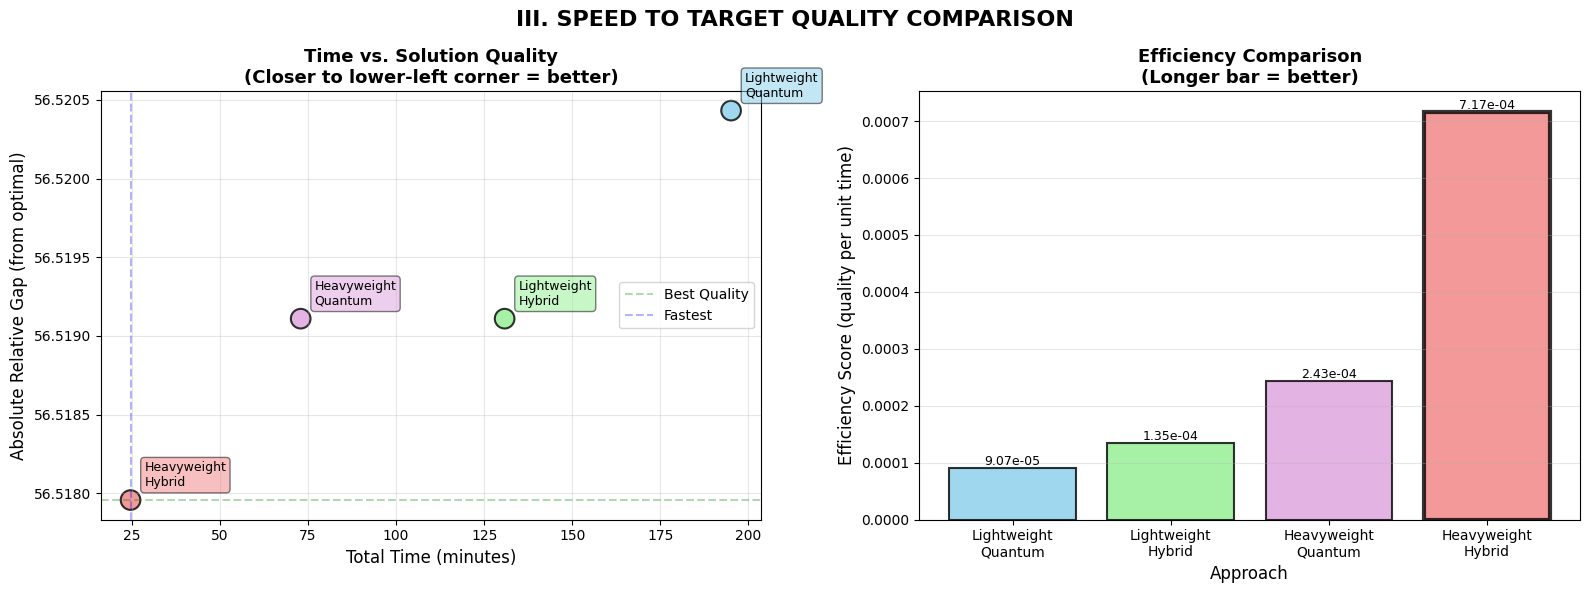

In [23]:
# create visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('III. SPEED TO TARGET QUALITY COMPARISON', fontsize=16, fontweight='bold')

# prepare data
experiment_names = [name.replace('_', '\n') for name in df_speed['experiment_id']]
times = df_speed['total_time_minutes'].values
gaps = df_speed['absolute_relative_gap'].values
colors = ['skyblue' if 'Quantum' in name and 'Lightweight' in name else
          'plum' if 'Quantum' in name and 'Heavyweight' in name else
          'lightgreen' if 'Hybrid' in name and 'Lightweight' in name else
          'lightcoral' for name in df_speed['experiment_id']]

######################################################################################
# plot 1: scatter plot - time vs. quality

axes[0].scatter(times, gaps, s=200, c=colors, alpha=0.8, edgecolors='black', linewidth=1.5)

# add labels for each point
for i, (time, gap, name) in enumerate(zip(times, gaps, experiment_names)):
    axes[0].annotate(name, (time, gap), xytext=(10, 10), textcoords='offset points',
                    fontsize=9, ha='left', bbox=dict(boxstyle='round,pad=0.3', 
                    facecolor=colors[i], alpha=0.5))

axes[0].set_xlabel('Total Time (minutes)', fontsize=12)
axes[0].set_ylabel('Absolute Relative Gap (from optimal)', fontsize=12)
axes[0].set_title('Time vs. Solution Quality\n(Closer to lower-left corner = better)', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# highlight best region
axes[0].axhline(y=min(gaps), color='green', linestyle='--', alpha=0.3, label='Best Quality')
axes[0].axvline(x=min(times), color='blue', linestyle='--', alpha=0.3, label='Fastest')
axes[0].legend(fontsize=10)

######################################################################################
# plot 2: bar chart - efficiency comparison

x = np.arange(len(experiment_names))
efficiencies = df_speed['efficiency'].values
bars = axes[1].bar(x, efficiencies, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)

axes[1].set_xlabel('Approach', fontsize=12)
axes[1].set_ylabel('Efficiency Score (quality per unit time)', fontsize=12)
axes[1].set_title('Efficiency Comparison\n(Longer bar = better)', fontsize=13, fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(experiment_names, rotation=0, ha='center', fontsize=10)
axes[1].grid(True, alpha=0.3, axis='y')

# add value labels on bars (show original values)
for bar, val in zip(bars, efficiencies):
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.2e}', ha='center', va='bottom', fontsize=9)

# highlight best approach
best_idx = np.argmax(efficiencies)
bars[best_idx].set_edgecolor('black')
bars[best_idx].set_linewidth(3)

######################################################################################

plt.tight_layout()
plt.show()

### III(c). Conclusion

**Question**: Which configuration reaches the standardized solution quality fastest?

**Answer**: Based on the data, the **heavyweight hybrid** configuration using the `TwoLocal` ansatz with `full` entanglement and low `reps = 2` (heavyweight shallow) offers the best quality per unit time.

## IV. "Other Factors"

### IV(a). Analysis

In [24]:
# compare additional factors
df_all[[col for col in ['experiment_id', 'device', 'optimizer', 'alpha', 'shots', 'theta_initial', 'theta_threshold', 'local_search_doe', 'lp_file', 'step3_fx_evals', 'step4_fx_evals'] if col in df_all.columns]]

,experiment_id,device,optimizer,alpha,shots,theta_initial,theta_threshold,local_search_doe,lp_file,step3_fx_evals,step4_fx_evals
0,Lightweight_Quantum,AerSimulator,nft,0.1,1024,piby3,None,None,31bonds/docplex-bin-avgonly-nocplexvars.lp,8191,NaN
1,Lightweight_Hybrid,AerSimulator,nft,0.1,1024,piby3,None,None,31bonds/docplex-bin-avgonly-nocplexvars.lp,4096,1366.0
2,Heavyweight_Quantum,AerSimulator,nft,0.1,1024,piby3,None,None,31bonds/docplex-bin-avgonly-nocplexvars.lp,2791,NaN
3,Heavyweight_Hybrid,AerSimulator,nft,0.1,1024,piby3,None,None,31bonds/docplex-bin-avgonly-nocplexvars.lp,1396,466.0


### IV(b). Conclusion

**Question**: What additional factors are likely to affect the performance of each approach?

**Answer**: Based on the data, all four experiments use identical settings, including the device, optimizer, penalty parameter (alpha), number of shots, and initialization strategy. However, one critical factor that differs across the experiments is the computational cost, which may significantly influence performance.

## V. "Computational Efficiency"

Before examining these differences, it is important to understand the distinction between epochs and function evaluations.

#### Epochs vs Function Evaluations

- **Epochs (Iterations):** The number of times the optimizer updates parameters. For example, configuring 10 epochs results in 10 parameter updates by the optimizer.

- **Function Evaluations:** The total number of times the objective function is called. This metric is **much more granular** than epochs. During each epoch, the optimizer typically calls the objective function hundreds or thousands of times (e.g., to estimate gradients, explore candidate solutions). 

Therefore, **function evaluations represent the true computational cost** since each call executes a quantum circuit.

***

### V(a). Analysis

The analysis creates a new `df_comp_cost` DataFrame with the following computed columns:

- Total Time (`total_time_seconds`, `total_time_minutes`): Represents the total time taken, provided in both seconds and minutes for convenience.
    - Computed by summing `step3_time` and `step4_time` for hybrid approaches.
    - Computed by using only `step3_time` for quantum-only approaches.
***
- Total Function Evaluations (`total_fx_evals`): Represents the total computational cost in terms of objective function calls. Lower values indicate less computational work required.
    - Computed by summing `step3_fx_evals` and `step4_fx_evals` for hybrid approaches.
    - Computed by using only `step3_fx_evals` for quantum-only approaches.
***
- Evaluation Throughput (`evaluation_throughput`): Represents the rate at which function evaluations are performed, measured in evaluations per second. Higher values indicate better computational efficiency (more evaluations completed in less time).
    - Computed as function evaluations per unit time (per second in this case): $$\mathrm{evaluation\_throughput}=\frac{\mathrm{total\_fx\_evals}}{\mathrm{total\_time\_seconds}}$$

In [25]:
# create summary data
comp_cost_analysis = []

for idx, row in df_all.iterrows():
    exp_id = row['experiment_id']
    
    if row['has_step4']:  # hybrid approach
        total_fx_evals = row['step3_fx_evals'] + row['step4_fx_evals']
        total_time = row['step3_time'] + row['step4_time']
    else:  # quantum-only approach
        total_fx_evals = row['step3_fx_evals']
        total_time = row['step3_time']
    
    comp_cost_analysis.append({
        'experiment_id': exp_id,
        'total_fx_evals': total_fx_evals,
        'total_time_seconds': total_time,
        'total_time_minutes': total_time / 60,
        'evaluation_throughput': total_fx_evals / total_time if total_time > 0 else 0
    })

# create computational cost DataFrame
df_comp_cost = pd.DataFrame(comp_cost_analysis)

# display computational cost DataFrame
df_comp_cost

,experiment_id,total_fx_evals,total_time_seconds,total_time_minutes,evaluation_throughput
0,Lightweight_Quantum,8191.0,11703.833385,195.063890,0.699856
1,Lightweight_Hybrid,5462.0,7848.477702,130.807962,0.695931
2,Heavyweight_Quantum,2791.0,4376.981879,72.949698,0.637654
3,Heavyweight_Hybrid,1862.0,1480.922868,24.682048,1.257324


### V(b). Visualization

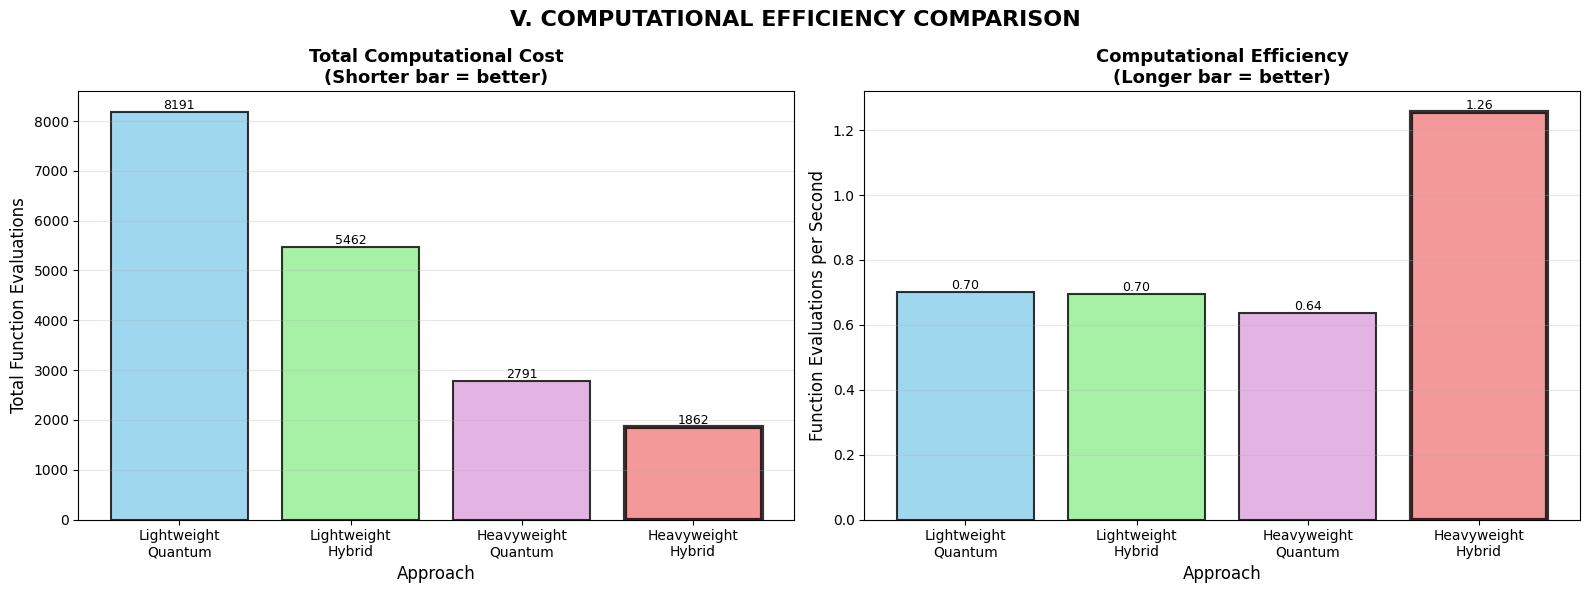

In [26]:
# create visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('V. COMPUTATIONAL EFFICIENCY COMPARISON', fontsize=16, fontweight='bold')

# prepare data
experiment_names = [name.replace('_', '\n') for name in df_comp_cost['experiment_id']]
total_fx_evals = df_comp_cost['total_fx_evals'].values
evaluation_throughput = df_comp_cost['evaluation_throughput'].values
colors = ['skyblue' if 'Quantum' in name and 'Lightweight' in name else
          'plum' if 'Quantum' in name and 'Heavyweight' in name else
          'lightgreen' if 'Hybrid' in name and 'Lightweight' in name else
          'lightcoral' for name in df_comp_cost['experiment_id']]

######################################################################################
# plot 1: total function evaluations

x = np.arange(len(experiment_names))
bars1 = axes[0].bar(x, total_fx_evals, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)

axes[0].set_xlabel('Approach', fontsize=12)
axes[0].set_ylabel('Total Function Evaluations', fontsize=12)
axes[0].set_title('Total Computational Cost\n(Shorter bar = better)', fontsize=13, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(experiment_names, rotation=0, ha='center', fontsize=10)
axes[0].grid(True, alpha=0.3, axis='y')

# add value labels on bars (show original values)
for bar, val in zip(bars1, total_fx_evals):
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height,
                f'{int(val)}', ha='center', va='bottom', fontsize=9)

# highlight best approach
best_idx = np.argmin(total_fx_evals)
bars1[best_idx].set_edgecolor('black')
bars1[best_idx].set_linewidth(3)

######################################################################################
# plot 2: function evaluations per unit time

bars2 = axes[1].bar(x, evaluation_throughput, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)

axes[1].set_xlabel('Approach', fontsize=12)
axes[1].set_ylabel('Function Evaluations per Second', fontsize=12)
axes[1].set_title('Computational Efficiency\n(Longer bar = better)', fontsize=13, fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(experiment_names, rotation=0, ha='center', fontsize=10)
axes[1].grid(True, alpha=0.3, axis='y')

# add value labels on bars (show original values)
for bar, val in zip(bars2, evaluation_throughput):
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.2f}', ha='center', va='bottom', fontsize=9)

# highlight best approach
best_idx = np.argmax(evaluation_throughput)
bars2[best_idx].set_edgecolor('black')
bars2[best_idx].set_linewidth(3)

######################################################################################

plt.tight_layout()
plt.show()

### V(c). Conclusion

**Question**: Which approach minimizes computational cost while maintaining throughput?

**Answer**: Based on the data, the **heavyweight hybrid** approach requires the fewest function evaluations and achieves the highest evaluation throughput, measured in function evaluations per unit time.
 
## Selecting the Best Approach

1. **Conclusion I**: Using a hybrid approach (i.e., adding local search) does not improve solution quality.
2. **Conclusion II**: The choice of ansatz, entanglement, or circuit depth shows no significant difference in solution quality.
3. **Conclusion III**: The **heavyweight hybrid** approach is the fastest configuration.
4. **Conclusion IV**: Computational cost is one of the key differentiators affecting overall performance.
5. **Conclusion V**: The **heavyweight hybrid** approach requires the lowest computational cost.

The **heavyweight hybrid** approach is the best because:
- It is the fastest approach (Conclusion III)
- It has the lowest computational cost (Conclusion V)
- However, this is not due to the use of local search (Conclusion I)
- Nor is it due to the use of the TwoLocal ansatz with full entanglement and a low number of repetitions (reps = 2) (Conclusion II)

## Saving Configuration for the Best Approach

In [27]:
# get the heavyweight hybrid experiment
best_experiment_id = 'Heavyweight_Hybrid'
hw_hybrid_exp = next((exp for exp in experiments if exp.experiment_id == best_experiment_id), None)

if hw_hybrid_exp is None:
    print(f"ERROR: {best_experiment_id} not found in experiments!")
else:
    # basic configuration
    print("\n1. CONFIGURATION FOR HARDWARE DEPLOYMENT:")
    print(f"   Ansatz:            {hw_hybrid_exp.ansatz}")
    print(f"   Parameters:        {hw_hybrid_exp.ansatz_params}")
    print(f"   Optimizer:         {hw_hybrid_exp.optimizer}")
    print(f"   Penalty (Alpha):   {hw_hybrid_exp.alpha}")
    print(f"   Shots:             {hw_hybrid_exp.shots}")
    print(f"   Theta Initial:     {hw_hybrid_exp.theta_initial}")
    print(f"   Theta Threshold:   {hw_hybrid_exp.theta_threshold}")
    print(f"   Local Search DOE:  {hw_hybrid_exp.local_search_doe}")
    print(f"   LP File:           {hw_hybrid_exp.lp_file}")
    
    # performance summary
    print("\n2. EXPECTED PERFORMANCE (from simulation):")
    hw_row = df_comparison[df_comparison['experiment_id'] == best_experiment_id].iloc[0]
    hw_speed = df_speed[df_speed['experiment_id'] == best_experiment_id].iloc[0]
    hw_cost = df_comp_cost[df_comp_cost['experiment_id'] == best_experiment_id].iloc[0]
    
    print(f"   Total Time:                   ~{(hw_hybrid_exp.step3_time + hw_hybrid_exp.step4_time)/60:.2f} minutes")
    print(f"   Total Function Evaluations:   {int(hw_cost['total_fx_evals'])}")
    print(f"   Final Relative Gap:           {hw_row['step4_relative_gap']:.6f}")
    print(f"   Efficiency Score:             {hw_speed['efficiency']:.6e}")

    # save minimal configuration for hardware deployment
    best_config = {
        'problem': {
            'lp_file': hw_hybrid_exp.lp_file
        },
        'quantum_circuit': {
            'ansatz': hw_hybrid_exp.ansatz,
            'ansatz_params': hw_hybrid_exp.ansatz_params,
            'shots': hw_hybrid_exp.shots
        },
        'optimization': {
            'optimizer': hw_hybrid_exp.optimizer,
            'alpha': hw_hybrid_exp.alpha,
            'theta_initial': hw_hybrid_exp.theta_initial,
            'theta_threshold': hw_hybrid_exp.theta_threshold
        },
        'hybrid': {
            'use_local_search': True,
            'local_search_doe': hw_hybrid_exp.local_search_doe
        }
    }
    
    # save configuration to file
    config_filename = ROOT / "project" / "best_config_heavyweight_hybrid.json"
    with open(config_filename, 'w') as f:
        json.dump(best_config, f, indent=2)
    
    print("\n" + "=" * 80 + "\n")
    print(f"This configuration file contains all parameters needed to replicate the best approach on real quantum hardware: {config_filename}")


1. CONFIGURATION FOR HARDWARE DEPLOYMENT:
   Ansatz:            TwoLocal
   Parameters:        {'reps': 2, 'entanglement': 'full'}
   Optimizer:         nft
   Penalty (Alpha):   0.1
   Shots:             1024
   Theta Initial:     piby3
   Theta Threshold:   None
   Local Search DOE:  None
   LP File:           31bonds/docplex-bin-avgonly-nocplexvars.lp

2. EXPECTED PERFORMANCE (from simulation):
   Total Time:                   ~24.68 minutes
   Total Function Evaluations:   1862
   Final Relative Gap:           -56.517957
   Efficiency Score:             7.168567e-04


This configuration file contains all parameters needed to replicate the best approach on real quantum hardware: C:\Users\ASUS\Downloads\WISER_Optimization_VG-main\project\best_config_heavyweight_hybrid.json


# Approach Analysis Conclusion

**Heavyweight Hybrid** (TwoLocal + local search) is the best.